# Mobile Games: A/B Testing & Player Retention

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. load data and check missing value

In [3]:
df = pd.read_excel('cookie_cats.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116.0,gate_30,3.0,False,False
1,337.0,gate_30,38.0,True,False
2,377.0,gate_40,165.0,True,False
3,483.0,gate_40,1.0,False,False
4,488.0,gate_40,179.0,True,True


In [4]:
df.info()
# there is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   userid          90189 non-null  float64
 1   version         90189 non-null  object 
 2   sum_gamerounds  90189 non-null  float64
 3   retention_1     90189 non-null  bool   
 4   retention_7     90189 non-null  bool   
dtypes: bool(2), float64(2), object(1)
memory usage: 2.2+ MB


# 2. check outliers

In [5]:
df.describe()
# max is significant bigger than 75%, so it is possible there is outlier

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


<AxesSubplot:ylabel='sum_gamerounds'>

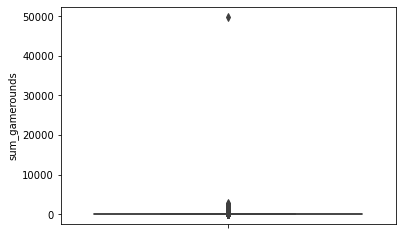

In [8]:
sns.boxplot(y = df['sum_gamerounds'])

In [14]:
# 非常明显有outliter, take a look
outlier = df['sum_gamerounds']>40000
df[outlier]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605.0,gate_30,49854.0,False,True


In [15]:
# 该异常值看起来有一个用户，完了49854关，有可能是通过作弊器通关，会影响后续的analysis，因此选择删除
df = df[-outlier]

In [17]:
df['userid'].value_counts().sort_values()
#确认没有重复user

116.0        1
488.0        1
540.0        1
1066.0       1
1444.0       1
            ..
9994217.0    1
9997049.0    1
9996999.0    1
9974108.0    1
9999861.0    1
Name: userid, Length: 90188, dtype: int64

In [18]:
#check balance
df['version'].value_counts()


gate_40    45489
gate_30    44699
Name: version, dtype: int64

# 3. compare gamerounds distribution by different version

In [25]:
df1 = df.groupby(['version','sum_gamerounds'])['userid'].count().reset_index()
df1.head()

,version,sum_gamerounds,userid
0,gate_30,0.0,1937
1,gate_30,1.0,2749
2,gate_30,2.0,2198
3,gate_30,3.0,1899
4,gate_30,4.0,1831


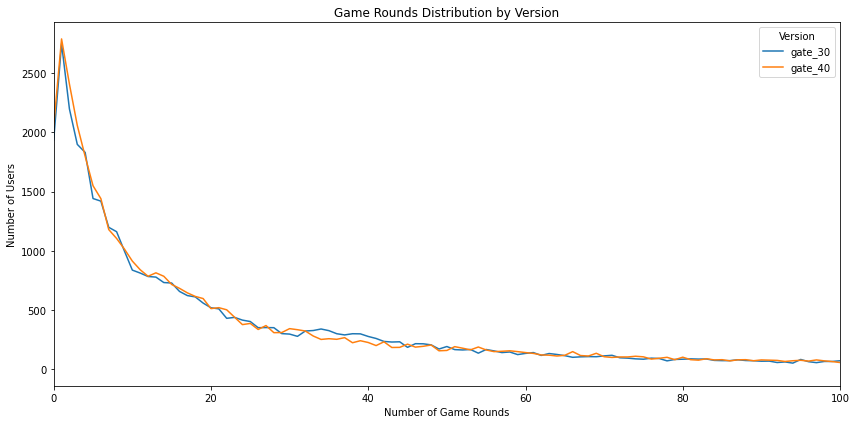

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = df1, x = 'sum_gamerounds', y = 'userid', hue = 'version')

plt.title('Game Rounds Distribution by Version')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Users')
plt.xlim(0, 100)  # 限制横轴最大值避免长尾干扰
plt.legend(title='Version')
plt.tight_layout()
plt.show()

# 看起来，gate_30和gate_40的用户行为并没有太大的区别，大部分用户都在前几个rounds就不再玩了，因此0-20 round，user量下降很快
# 但是round 20之后，user就比较稳定了，下降的幅度也比较小
# 两组user的行为看起来在30-40rounds是，gate_30这一组的user稍稍多一些，但around 45round之后，和gate_40就没有明显区别了，且趋于稳定了


# 4. booststraping-retention 1

In [75]:
df.groupby('version')['retention_1'].mean()

# gate_30的第一天的留存率为44.81%， gate_40的为44.23%,略低于gate_30
# 但不足以说明gate_30就好于gate_40
# 需要做statistics analysis


version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [76]:
#Bootstrapping 是非参数方法，不需要分布假设
#game rounds的distribution右偏，所以用bootstrapping比较合适

#重采样
df.sample(frac = 1, replace = True)

,userid,version,sum_gamerounds,retention_1,retention_7
8487,936031.0,gate_40,3.0,False,False
3908,433038.0,gate_30,296.0,True,True
22030,2452902.0,gate_30,31.0,True,False
72606,8043912.0,gate_40,7.0,False,False
66856,7403616.0,gate_40,6.0,False,False
...,...,...,...,...,...
13717,1520774.0,gate_30,57.0,False,False
34548,3827211.0,gate_40,43.0,False,False
17608,1962032.0,gate_30,13.0,False,False
20437,2272668.0,gate_40,29.0,True,False


In [84]:
#重复 1000 次，构造 bootstrap 分布 for each AB-group
boot_1d = []

for i in range(1000):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

In [85]:
boot_1d = pd.DataFrame(boot_1d)
boot_1d.head()

version,gate_30,gate_40
retention_1,0.448266,0.440378
retention_1,0.451468,0.441389
retention_1,0.446875,0.442421
retention_1,0.451169,0.439449
retention_1,0.445325,0.438321


<AxesSubplot:ylabel='Density'>

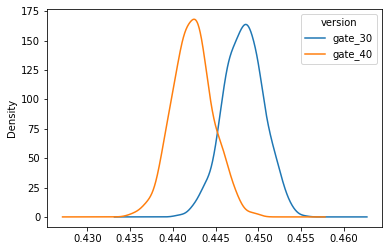

In [86]:
#Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind = 'density')

#从分布来看，gate_40的1d留存率整体要少于gate_30

In [87]:
#calculate % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_40'] - boot_1d['gate_30'])*100 / boot_1d['gate_30'] 

In [88]:
boot_1d.head()

version,gate_30,gate_40,diff
retention_1,0.448266,0.440378,-1.759663
retention_1,0.451468,0.441389,-2.232483
retention_1,0.446875,0.442421,-0.996676
retention_1,0.451169,0.439449,-2.597605
retention_1,0.445325,0.438321,-1.572896


<AxesSubplot:ylabel='Density'>

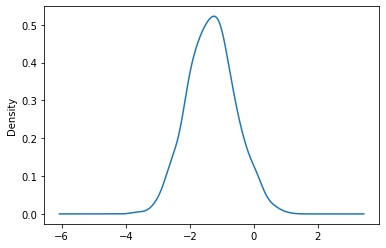

In [89]:
boot_1d['diff'].plot(kind = 'density')

In [90]:
prob = (boot_1d['diff']<0).mean()
prob
# 95.4% of distribution is less than 0, 说明有95.4%的概率gate_40变差了

0.954

# 5. retention 7

In [91]:
df.groupby('version')['retention_7'].mean()
#看起来gate_40的7天留存率比gate_30低了0.8%

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

In [92]:
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

In [93]:
boot_7d = pd.DataFrame(boot_7d)
boot_7d.head()

version,gate_30,gate_40
retention_7,0.187680,0.184811
retention_7,0.188504,0.188508
retention_7,0.191361,0.182301
retention_7,0.189557,0.183201
retention_7,0.188902,0.184648


<AxesSubplot:ylabel='Density'>

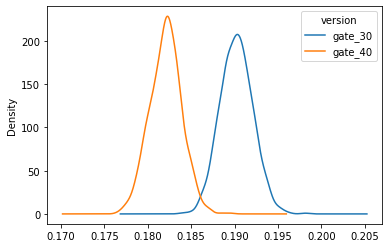

In [94]:
boot_7d.plot(kind = 'density')

<AxesSubplot:ylabel='Density'>

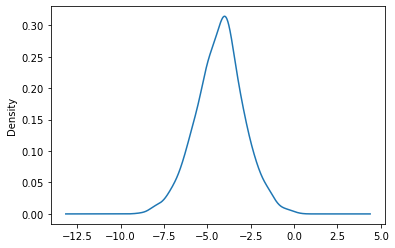

In [96]:
boot_7d['diff'] = (boot_7d['gate_40'] - boot_7d['gate_30'])*100 / boot_7d['gate_30'] 
boot_7d['diff'].plot(kind = 'density')

In [97]:
(boot_7d['diff']<0).mean()

0.999

In [98]:
#从上图可以看出来 有99.9%的概率gate_30的7天留存率优于gate_40

从bootstrap的分析结果来看，在有99.9%的概率gate_30的7天留存率优于gate_40，这是非常显著的

因此，保留gate_30比较好，因为会有较高的1天以及7天的留存率

可能的解释：

如果关卡被推迟到第 40 级，玩家会更可能在中途就感到厌倦，没有足够的耐心坚持到40级就会退出游戏，因此留存率会就下降了

但是这不能解释为什么一天的留存率也降低了？

猜测，是否是因为玩家感知目标更远，降低了动力？有待验证。

In [104]:
#使用package

from scikits.bootstrap import ci


gate_30 = df[df['version'] == 'gate_30']['retention_7']
gate_40 = df[df['version'] == 'gate_40']['retention_7']

# 计算 gate_30、40 的均值的 95% bootstrap 置信区间
ci_gate_30 = ci(data=gate_30.values, statfunction=np.mean, alpha=0.05)
ci_gate_40 = ci(data=gate_40.values, statfunction=np.mean, alpha=0.05)

print("Gate 30 retention 95% CI:", ci_gate_30)
print("Gate 40 retention 95% CI:", ci_gate_40)


Gate 30 retention 95% CI: [0.18667084 0.1937851 ]
Gate 40 retention 95% CI: [0.17848271 0.18549539]


# 6. EDA+Correlation Relationship

In [109]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116.0,gate_30,3.0,False,False
1,337.0,gate_30,38.0,True,False
2,377.0,gate_40,165.0,True,False
3,483.0,gate_40,1.0,False,False
4,488.0,gate_40,179.0,True,True


<AxesSubplot:xlabel='retention_day', ylabel='retention_rate'>

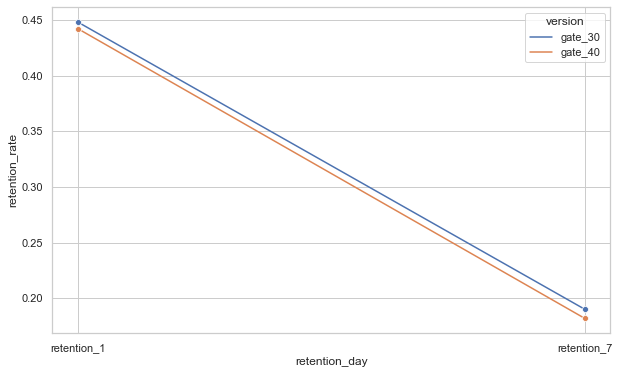

In [118]:
# False=0, True=1
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)


retention_means = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()

retention_long = retention_means.melt(id_vars='version', 
                                      value_vars=['retention_1', 'retention_7'],
                                      var_name='retention_day',
                                      value_name='retention_rate')

# plot
plt.figure(figsize=(10,6))
sns.lineplot(data=retention_long, x='retention_day', y='retention_rate', hue='version', marker='o')

#可以看出来，整体gate_30的留存率是好于gate_40的
#并且gate_30与gate_40的留存率的差距逐渐拉大


In [123]:
avg_gamerounds = df.groupby(['version','retention_1','retention_7'])['sum_gamerounds'].mean().reset_index()


In [124]:
avg_gamerounds

,version,retention_1,retention_7,sum_gamerounds
0,gate_30,0,0,11.819746
1,gate_30,0,1,73.169315
2,gate_30,1,0,49.694490
3,gate_30,1,1,183.886309
4,gate_40,0,0,11.913294
5,gate_40,0,1,75.261139
6,gate_40,1,0,50.025490
7,gate_40,1,1,190.282355


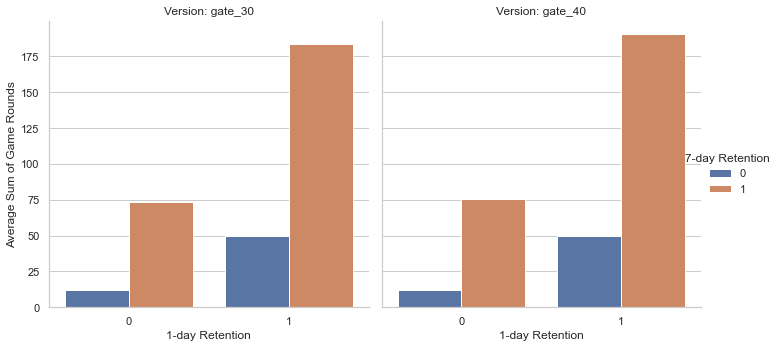

In [127]:
g = sns.catplot(
    data=avg_gamerounds,
    x='retention_1',
    y='sum_gamerounds',
    hue='retention_7',
    col='version',
    kind='bar',
    height=5,
    aspect=1
)

g.set_axis_labels("1-day Retention", "Average Sum of Game Rounds")
g.set_titles("Version: {col_name}")
g._legend.set_title("7-day Retention")

plt.show()

从图里看，7天都留下来的玩家，在gate_40的情况下，玩的关数比较多

因此我们认为，gate_40对于能坚持玩下来的玩家来说，是可以提高玩家玩的关数的，但是大部分的玩家没有耐心



In [132]:
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

#sum_gamerounds分成7份，label从1到7
df['gamerounds_bin'] = pd.qcut(df['sum_gamerounds'], 7, labels=[1,2,3,4,5,6,7])
df['gamerounds_bin'] = df['gamerounds_bin'].astype(int)

retention_by_bin = df.groupby('gamerounds_bin').agg(
    retention_1_rate = ('retention_1', 'mean'),
    retention_7_rate = ('retention_7', 'mean')
).reset_index()

In [133]:
retention_by_bin

,gamerounds_bin,retention_1_rate,retention_7_rate
0,1,0.037629,0.009690
1,2,0.120461,0.018080
2,3,0.257069,0.036356
3,4,0.427001,0.072561
4,5,0.630745,0.146817
5,6,0.786403,0.325492
6,7,0.899116,0.705717


In [134]:
#correlation 
retention_by_bin.corr()

,gamerounds_bin,retention_1_rate,retention_7_rate
gamerounds_bin,1.000000,0.994993,0.856184
retention_1_rate,0.994993,1.000000,0.855282
retention_7_rate,0.856184,0.855282,1.000000


<AxesSubplot:>

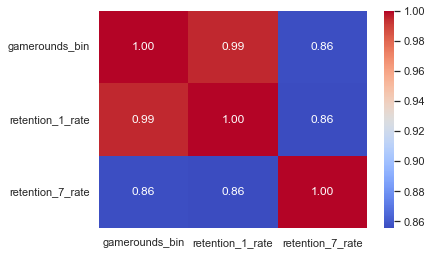

In [135]:
sns.heatmap(retention_by_bin.corr(), annot=True, fmt=".2f", cmap = "coolwarm")

#从图里来看，留存率和玩家玩的关数是有明显正相关性的
#且1天留存率和7天留存率也是有明显正相关性的


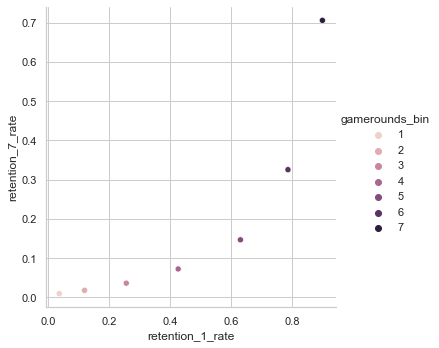

In [141]:
sns.color_palette('pastel')
sns.relplot(data=retention_by_bin, kind='scatter', x='retention_1_rate',y='retention_7_rate',hue='gamerounds_bin')
plt.show()

#从图里可以看出，user玩的关数与留存率是成正相关的

#当玩家的第一天的留存率越高，在第七天的留存率也越高，且是成指数增长的，同时玩家玩的总关数也会更高

#suprisingly, 这张图看起来是可以通过第一天的留存率来预测第七天的留存率，以及玩家会玩的总关数